In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dat200-ca4-2023/sample_submission.csv
/kaggle/input/dat200-ca4-2023/train.csv
/kaggle/input/dat200-ca4-2023/test.csv


In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.svm import LinearSVC
from sklearn.impute import KNNImputer


import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_colwidth', None)

# 1. DATA CLEANING

In [3]:
raw_train = pd.read_csv('/kaggle/input/dat200-ca4-2023/train.csv', index_col = 0)
raw_test = pd.read_csv('/kaggle/input/dat200-ca4-2023/test.csv', index_col = 0)

In [4]:
X = raw_train.drop("Stage", axis =1)
y = raw_train["Stage"]

X_f = raw_test.copy()

In [5]:
print(f'Shape: {X.shape}')
print(f'Shape: {X_f.shape}')
X.head(5)

Shape: (200, 18)
Shape: (109, 18)


N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
index                                                                           
0         980      D  D-penicillamine  18713   F       N            Y       Y   
1        1455      C          Placebo  12398   F       N            Y       N   
2         216      D          Placebo  19246   F       Y            Y       Y   
3        2216      C          Placebo  19221   F       N            Y       Y   
4        1701      C  D-penicillamine  11485   F       N            N       N   

      Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos     SGOT  \
index                                                                     
0         N        6.7        561.0    5.610   154.5    1468.5  192.975   
1         N        1.3        456.0    5.280   145.5    2433.0  106.500   
2         N       24.5       1638.0    5.025   349.5    5610.0  220.875   
3         N        0.7        201.6    3.208     8.8     968.0   58.280   
4         N        1.1        403.2    4.488    57.6     987.6  100.800   

       Tryglicerides  Platelets  Prothrombin  
index                                         
0              150.0      399.0        16.65  
1              253.5      382.5        14.25  
2              648.0      598.5        22.80  
3               46.4      247.2         7.60  
4              129.6      290.4        11.64

In [6]:
## Imputations

def do_impute(dataframe):
     
    sex_dict = {'F': 0, 'M': 1}
    ascites_dict = {'N': 0, 'Y': 1}
    hepatomegaly_dict = {'N': 0, 'Y': 1}
    spider_dict = {'N': 0, 'Y': 1}

    df1 = dataframe.copy()
    df1["Sex"] = df1["Sex"].replace(sex_dict)
    df1["Ascites"] = df1["Ascites"].replace(ascites_dict)
    df1["Hepatomegaly"] = df1["Hepatomegaly"].replace(hepatomegaly_dict)
    df1["Spiders"] = df1["Spiders"].replace(spider_dict)

    df2 = pd.get_dummies(df1, columns=["Status", "Drug", "Edema"], drop_first=True)
    return df2

X2 = do_impute(X)
X_f2 = do_impute(X_f)

print(X2.shape)
print(X_f2.shape)

(200, 20)
(109, 20)


In [7]:
X_f2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 108
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         109 non-null    int64  
 1   Age            109 non-null    int64  
 2   Sex            109 non-null    int64  
 3   Ascites        109 non-null    int64  
 4   Hepatomegaly   109 non-null    int64  
 5   Spiders        109 non-null    int64  
 6   Bilirubin      109 non-null    float64
 7   Cholesterol    100 non-null    float64
 8   Albumin        109 non-null    float64
 9   Copper         108 non-null    float64
 10  Alk_Phos       109 non-null    float64
 11  SGOT           109 non-null    float64
 12  Tryglicerides  98 non-null     float64
 13  Platelets      109 non-null    float64
 14  Prothrombin    109 non-null    float64
 15  Status_CL      109 non-null    uint8  
 16  Status_D       109 non-null    uint8  
 17  Drug_Placebo   109 non-null    uint8  
 18  Edema_S   

In [8]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         200 non-null    int64  
 1   Age            200 non-null    int64  
 2   Sex            200 non-null    int64  
 3   Ascites        200 non-null    int64  
 4   Hepatomegaly   200 non-null    int64  
 5   Spiders        200 non-null    int64  
 6   Bilirubin      200 non-null    float64
 7   Cholesterol    184 non-null    float64
 8   Albumin        200 non-null    float64
 9   Copper         199 non-null    float64
 10  Alk_Phos       200 non-null    float64
 11  SGOT           200 non-null    float64
 12  Tryglicerides  184 non-null    float64
 13  Platelets      196 non-null    float64
 14  Prothrombin    200 non-null    float64
 15  Status_CL      200 non-null    uint8  
 16  Status_D       200 non-null    uint8  
 17  Drug_Placebo   200 non-null    uint8  
 18  Edema_S   

In [9]:
X2.isna().sum()

N_Days            0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Bilirubin         0
Cholesterol      16
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    16
Platelets         4
Prothrombin       0
Status_CL         0
Status_D          0
Drug_Placebo      0
Edema_S           0
Edema_Y           0
dtype: int64

In [10]:
X_f2.isna().sum()

N_Days            0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Bilirubin         0
Cholesterol       9
Albumin           0
Copper            1
Alk_Phos          0
SGOT              0
Tryglicerides    11
Platelets         0
Prothrombin       0
Status_CL         0
Status_D          0
Drug_Placebo      0
Edema_S           0
Edema_Y           0
dtype: int64

In [11]:
#IMPUTER
imputer= KNNImputer(missing_values=np.nan, n_neighbors=5)
X3 = imputer.fit_transform(X2)
X_f3 = imputer.transform(X_f2)

# X3 = X2.fillna(X2.mean())
# X3.isna().sum()

# X_f3 = X_f2.fillna(X_f2.mean())
# X_f3.isna().sum()

In [12]:
visual_df = pd.DataFrame(X3, columns = X2.columns)
visual_df["Stage"] = y
visual_df.head(5)

N_Days      Age  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  \
0   980.0  18713.0  0.0      0.0           1.0      1.0        6.7   
1  1455.0  12398.0  0.0      0.0           1.0      0.0        1.3   
2   216.0  19246.0  0.0      1.0           1.0      1.0       24.5   
3  2216.0  19221.0  0.0      0.0           1.0      1.0        0.7   
4  1701.0  11485.0  0.0      0.0           0.0      0.0        1.1   

   Cholesterol  Albumin  Copper  ...     SGOT  Tryglicerides  Platelets  \
0        561.0    5.610   154.5  ...  192.975          150.0      399.0   
1        456.0    5.280   145.5  ...  106.500          253.5      382.5   
2       1638.0    5.025   349.5  ...  220.875          648.0      598.5   
3        201.6    3.208     8.8  ...   58.280           46.4      247.2   
4        403.2    4.488    57.6  ...  100.800          129.6      290.4   

   Prothrombin  Status_CL  Status_D  Drug_Placebo  Edema_S  Edema_Y  Stage  
0        16.65        0.0       1.0           0.0      0.0      0.0      4  
1        14.25        0.0       0.0           1.0      0.0      0.0      4  
2        22.80        0.0       1.0           1.0      0.0      0.0      4  
3         7.60        0.0       0.0           1.0      0.0      0.0      2  
4        11.64        0.0       0.0           0.0      0.0      0.0      3  

[5 rows x 21 columns]

# 2. Visualization

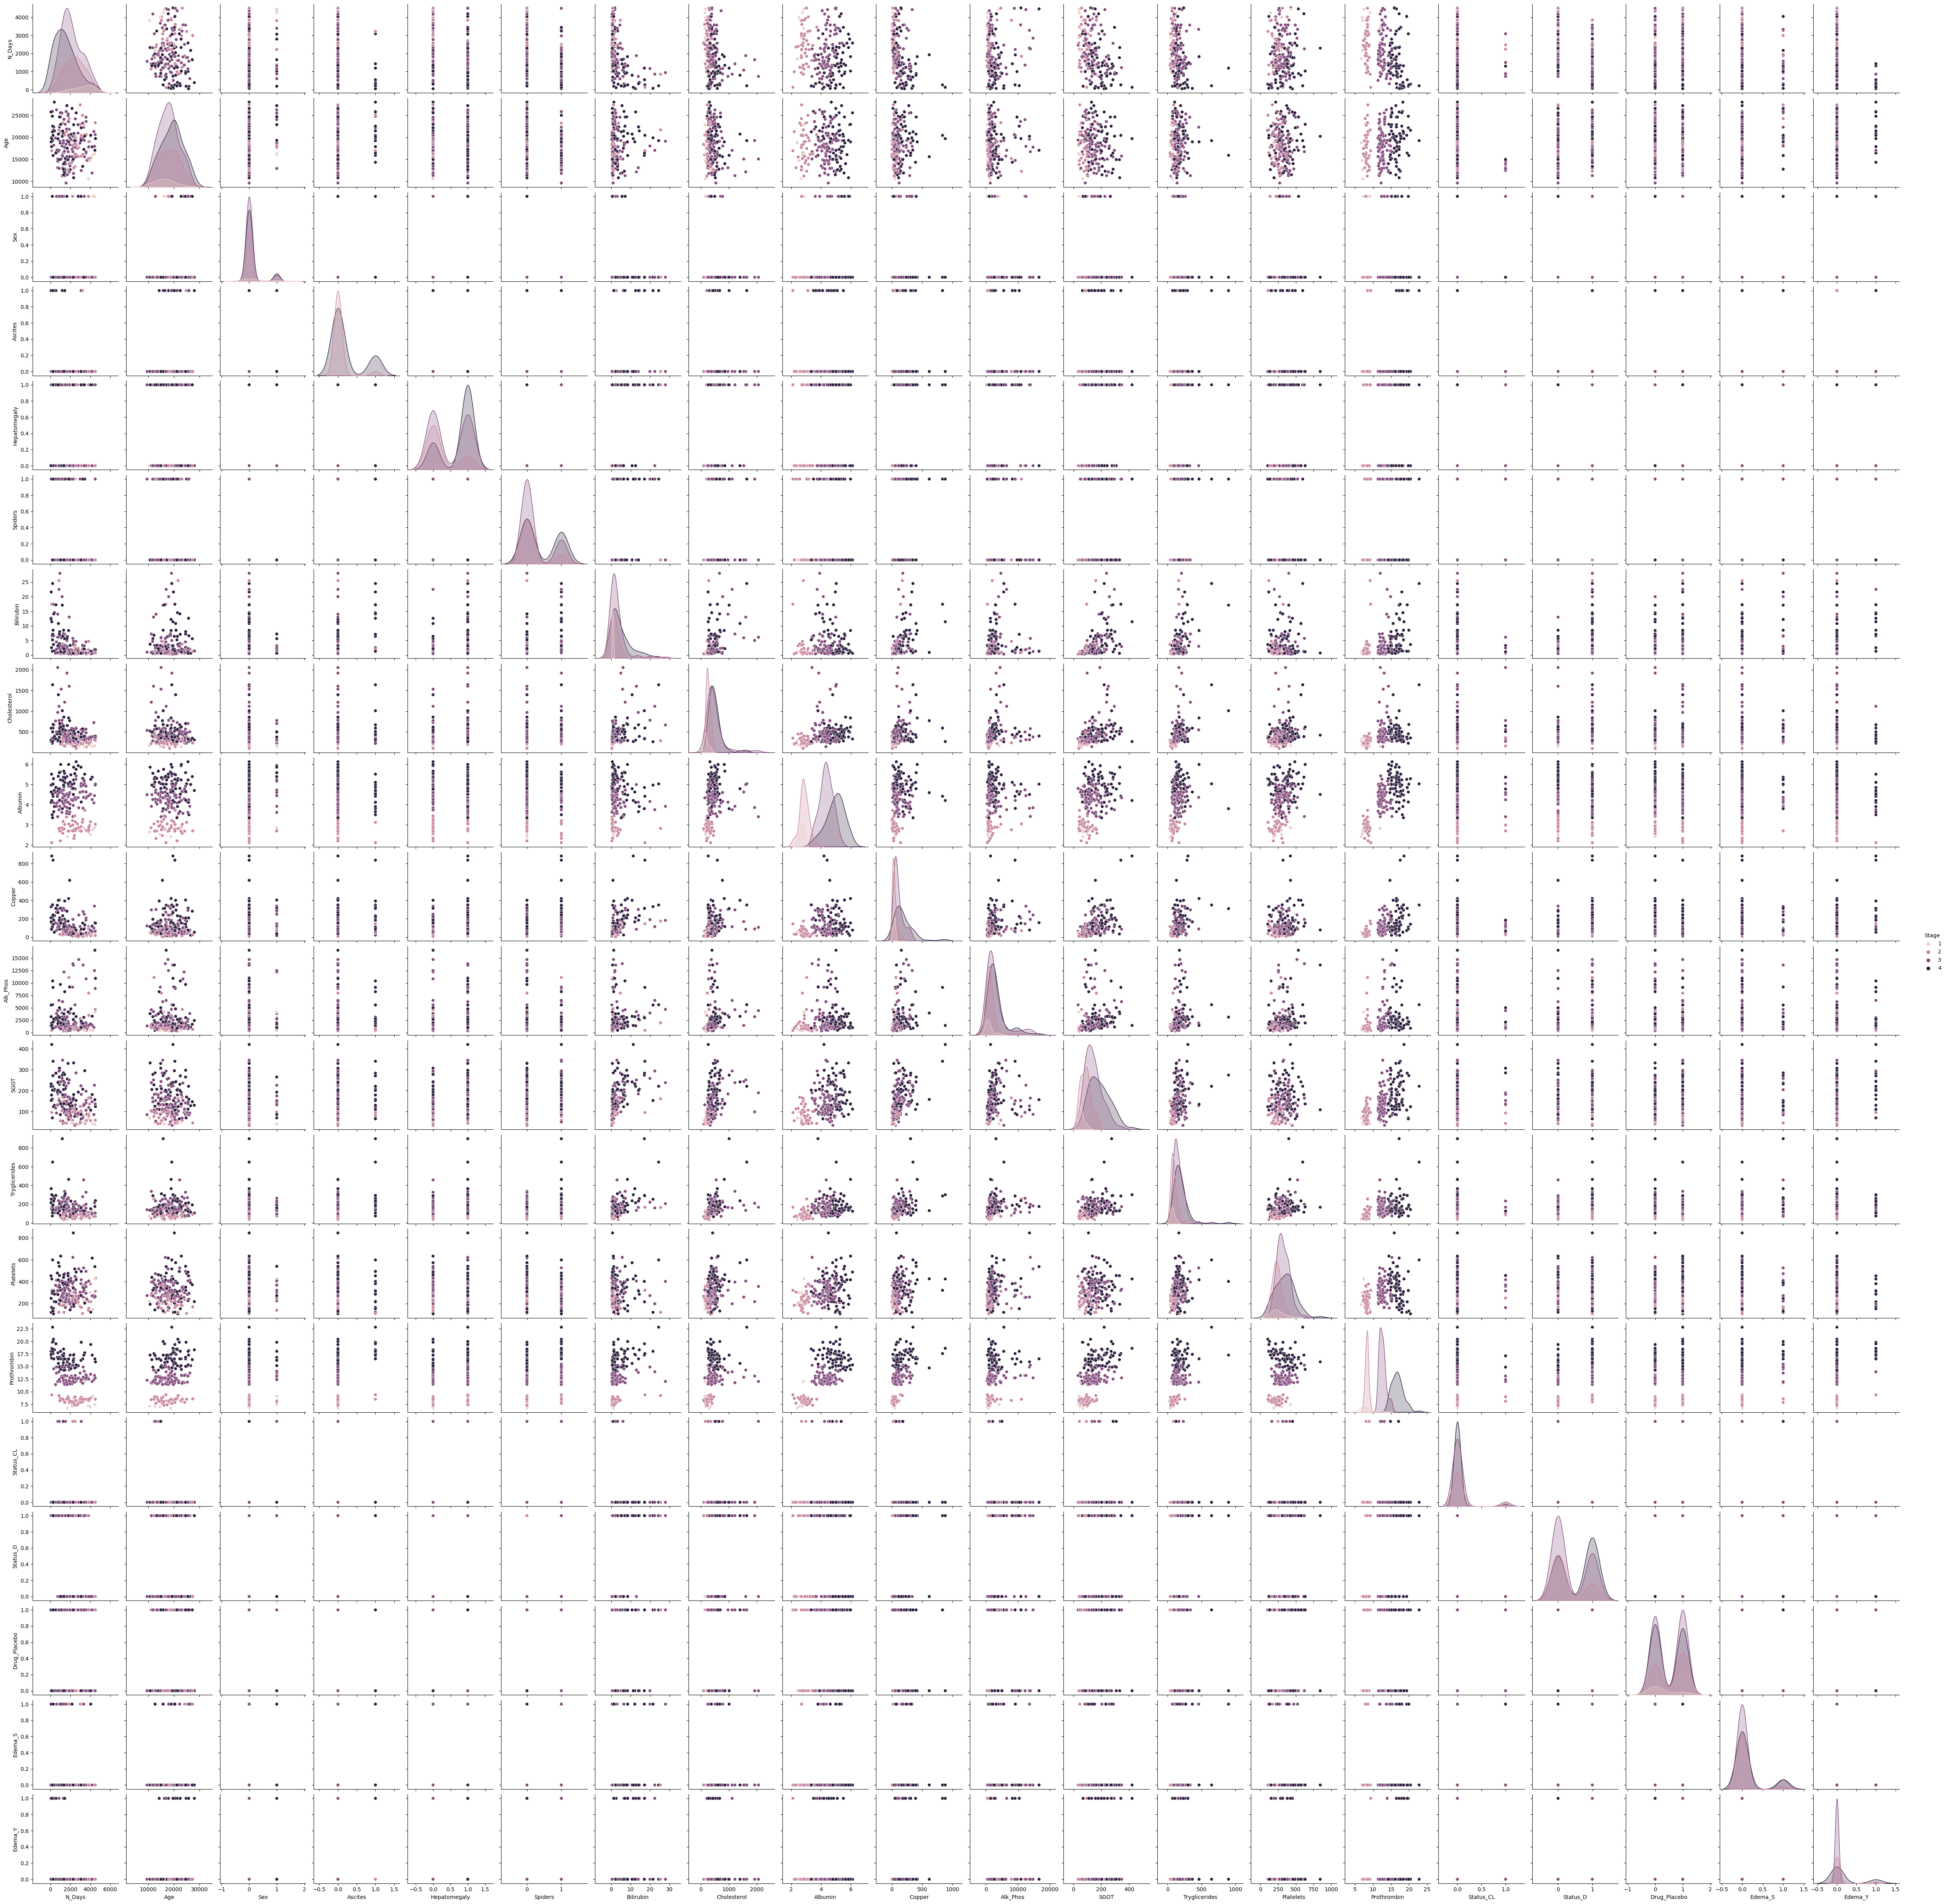

In [13]:
 sns.pairplot(visual_df, hue="Stage")

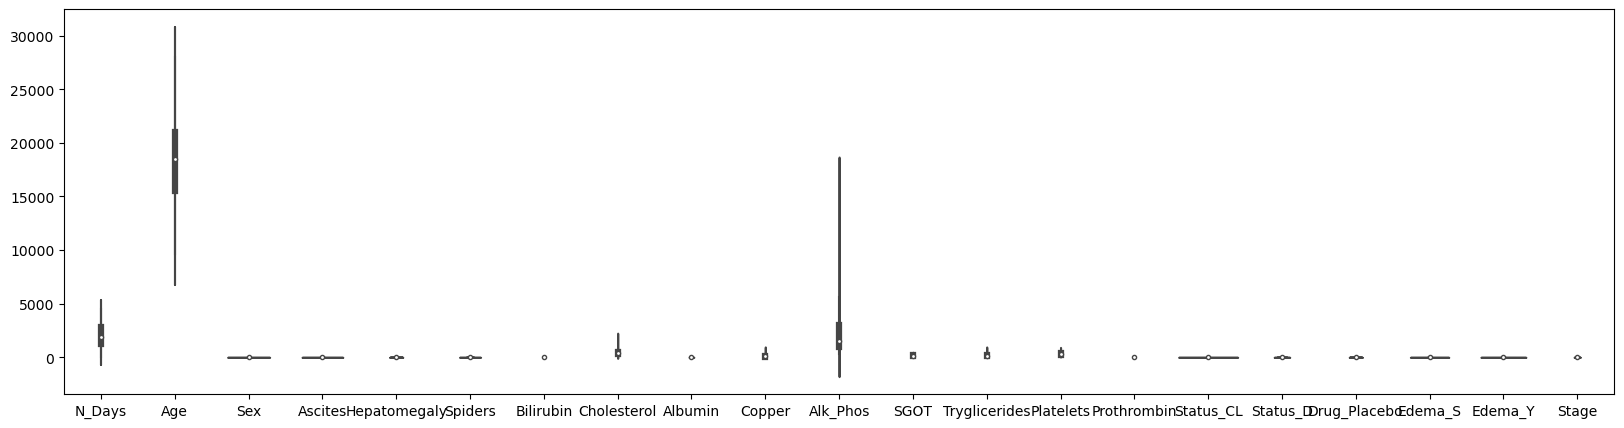

In [14]:
plt.figure(figsize=(20,5))
sns.violinplot(visual_df)
plt.show()

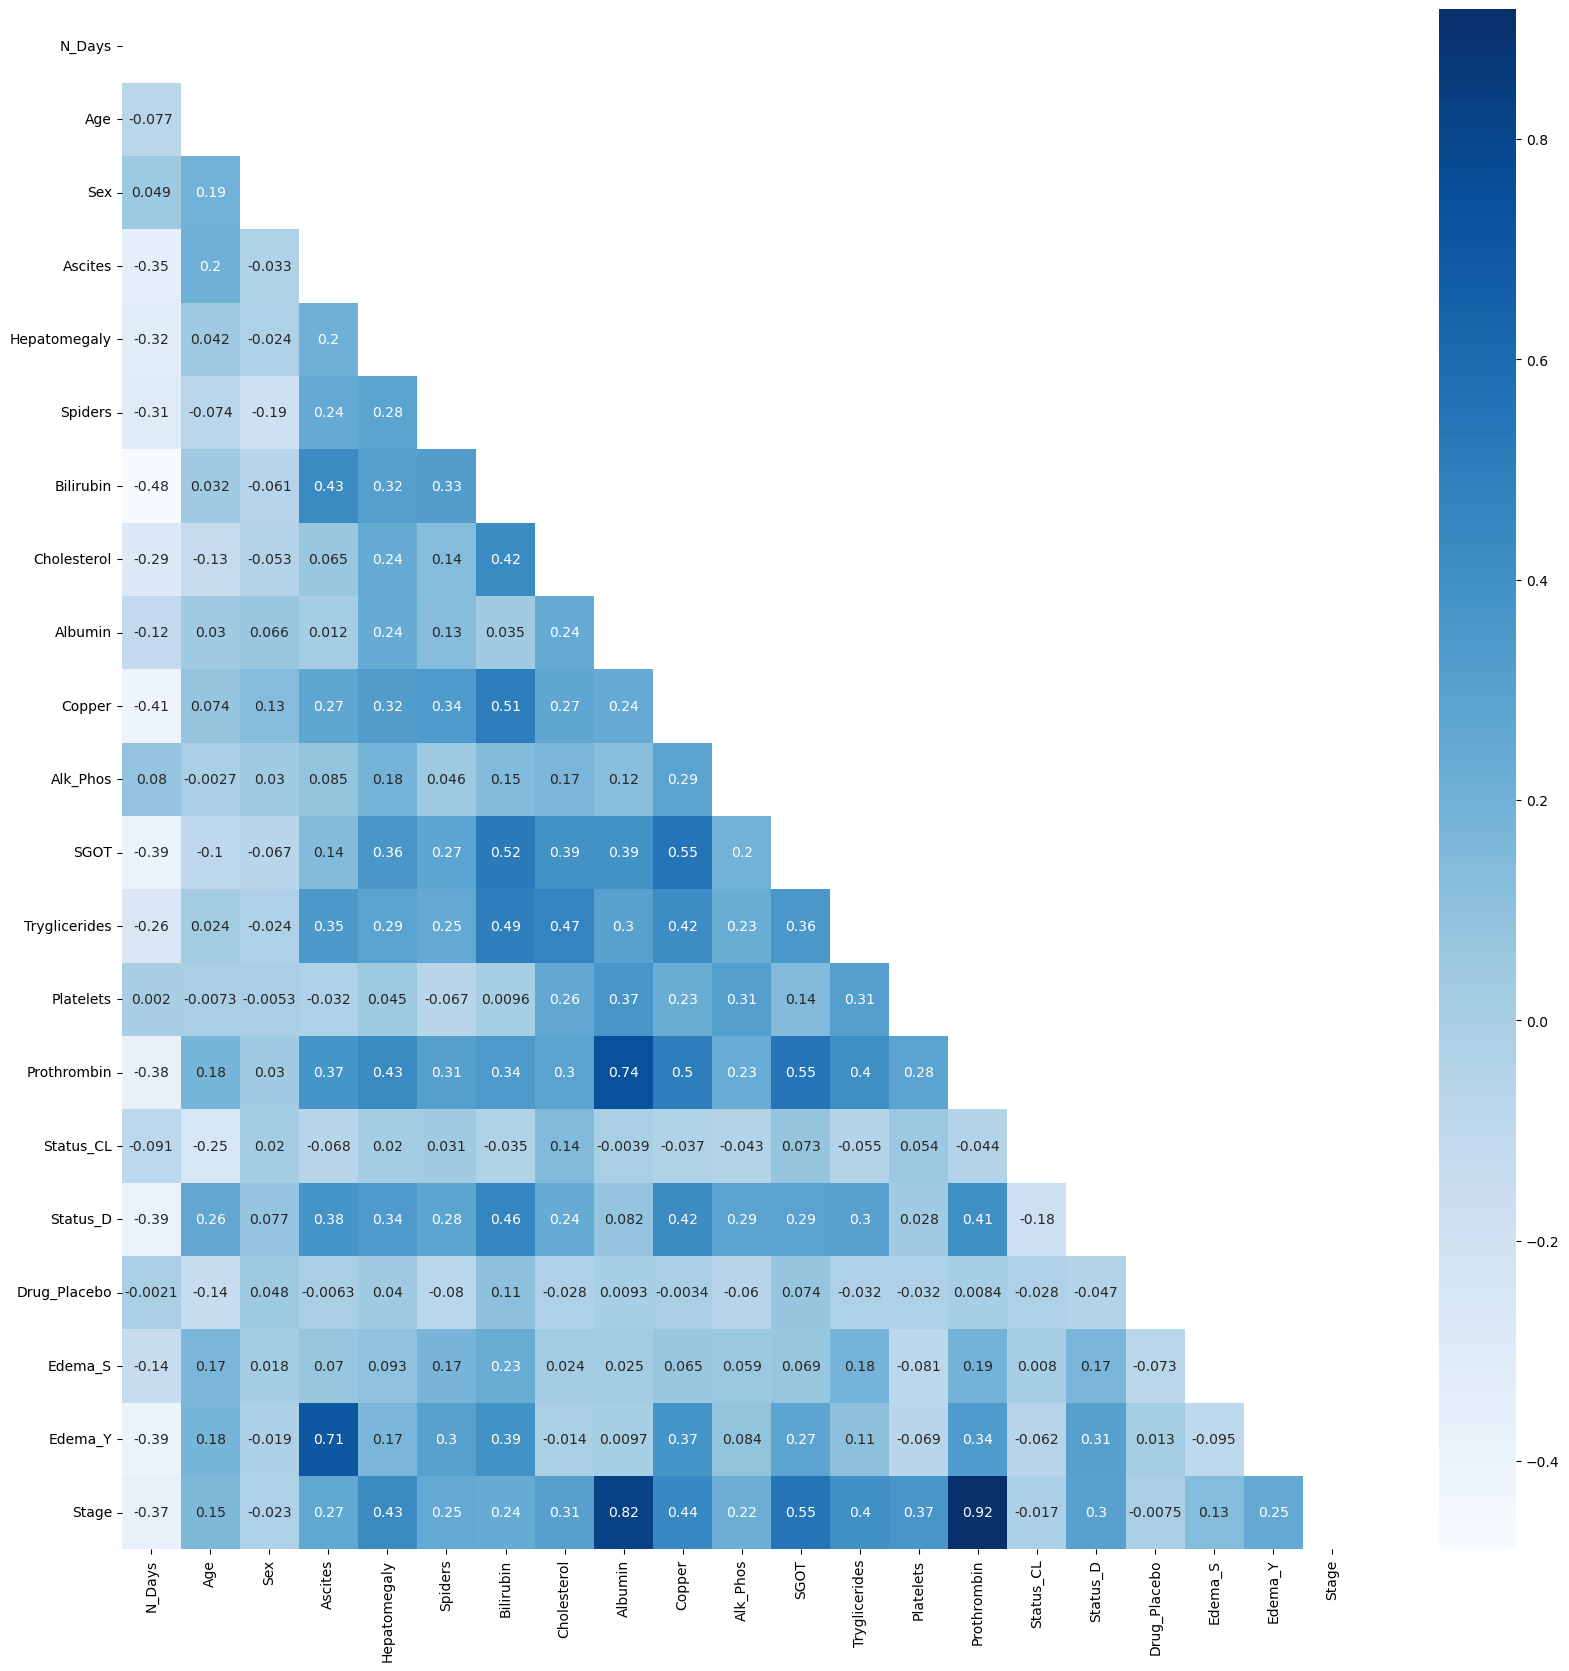

In [15]:
corr = visual_df.corr()
mask = np.triu(corr)

plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap="Blues")
plt.show()

# 3. Feature Selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=1234)

In [17]:
base_model = RandomForestClassifier(n_estimators=50, random_state=123)
sfm = SelectFromModel(estimator=base_model, threshold="median")
sfm.fit(X_train, y_train)

selected_cols = [x for x, v in zip(X2.columns, sfm.get_support()) if v]
print(f'Count : {len(selected_cols)}')
print(f'{selected_cols}')




Count : 10
['N_Days', 'Age', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [18]:
rfe = RFECV(estimator=base_model, min_features_to_select=9, cv=5)
rfe.fit(X_train, y_train)

selected_cols = [x for x, v in zip(X2.columns, rfe.get_support()) if v]
print(f'Count : {len(selected_cols)}')
print(f'{selected_cols}')

Count : 12
['N_Days', 'Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [19]:
from sklearn.metrics import accuracy_score

y_pred = rfe.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.925


In [20]:
X_train_final = rfe.transform(X3)
X_train2 = rfe.transform(X_train)
X_test2 = rfe.transform(X_test)
X_f4 = rfe.transform(X_f3)
print(X_train_final.shape)
print(X_train2.shape)
print(X_test2.shape)
print(X_f4.shape)

(200, 12)
(160, 12)
(40, 12)
(109, 12)


# 4. HyperParameter Selection

In [21]:
cv = StratifiedShuffleSplit(n_splits=5, random_state=123)

In [22]:
## SVC Pipeline
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=1234)),
    ('svc', SVC())
])
#pipe_svc.get_params()

param_svc = {
    'pca__n_components': [4,10,12],
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.01, 0.1, 1, 10, 100],
    'svc__kernel': ['rbf', 'linear'],
}

grid_svc = GridSearchCV(pipe_svc, 
                        param_grid=param_svc, 
                        cv=cv,
                        scoring = "f1_macro",
                       return_train_score=True)
grid_svc.fit(X_train2, y_train)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', grid_svc.best_params_)
print('Cross-validation score:', grid_svc.best_score_)

Best hyperparameters: {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
Cross-validation score: 0.883989343989344


In [23]:
results = pd.DataFrame(grid_svc.cv_results_, columns=grid_svc.cv_results_.keys())
results.sort_values(by="rank_test_score").head(5)[["params", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

params  \
81  {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}   
83   {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}   
85     {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'linear'}   
89   {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 100, 'svc__kernel': 'linear'}   
87    {'pca__n_components': 10, 'svc__C': 10, 'svc__gamma': 10, 'svc__kernel': 'linear'}   

    mean_train_score  std_train_score  mean_test_score  std_test_score  
81          0.955691         0.013525         0.883989         0.13035  
83          0.955691         0.013525         0.883989         0.13035  
85          0.955691         0.013525         0.883989         0.13035  
89          0.955691         0.013525         0.883989         0.13035  
87          0.955691         0.013525         0.883989         0.13035

In [24]:
grid_svc.set_params()
y_pred = grid_svc.predict(X_test2)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average=None)}')
print(f'Recall Score: {recall_score(y_test, y_pred , average=None)}')
print(f'Precision Score: {precision_score(y_test, y_pred , average=None)}')


Accuracy: 0.925
F1 Score: [0.5        0.875      0.96969697 0.96296296]
Recall Score: [0.5        0.875      1.         0.92857143]
Precision Score: [0.5        0.875      0.94117647 1.        ]


In [25]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear'))
])
# lr_pipe.get_params()
lr_param_grid = {
    'pca__n_components': [5,10, 12],
    'lr__C': [0.1, 1, 10, 100],
     'lr__max_iter': [1000]
}

## Create a GridSearchCV object to search over the hyperparameters
lr_grid = GridSearchCV(lr_pipe, 
                       param_grid= lr_param_grid, 
                       cv=cv,
                        scoring = "f1_macro",
                       return_train_score=True )
    
lr_grid.fit(X_train2, y_train)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', lr_grid.best_params_)
print('Cross-validation score:', lr_grid.best_score_)

Best hyperparameters: {'lr__C': 10, 'lr__max_iter': 1000, 'pca__n_components': 12}
Cross-validation score: 0.7397793872793872


In [26]:
results = pd.DataFrame(lr_grid.cv_results_, columns=lr_grid.cv_results_.keys())
results.sort_values(by="rank_test_score").head(5)[["params", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

params  \
8    {'lr__C': 10, 'lr__max_iter': 1000, 'pca__n_components': 12}   
9    {'lr__C': 100, 'lr__max_iter': 1000, 'pca__n_components': 5}   
11  {'lr__C': 100, 'lr__max_iter': 1000, 'pca__n_components': 12}   
5     {'lr__C': 1, 'lr__max_iter': 1000, 'pca__n_components': 12}   
10  {'lr__C': 100, 'lr__max_iter': 1000, 'pca__n_components': 10}   

    mean_train_score  std_train_score  mean_test_score  std_test_score  
8           0.888118         0.017664         0.739779        0.181516  
9           0.780203         0.033040         0.691195        0.142642  
11          0.970697         0.011827         0.682637        0.160603  
5           0.718778         0.006256         0.663693        0.031668  
10          0.868677         0.045741         0.660122        0.160768

In [27]:
lr_grid.set_params()
y_pred = lr_grid.predict(X_test2)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average=None)}')
print(f'Recall Score: {recall_score(y_test, y_pred , average=None)}')
print(f'Precision Score: {precision_score(y_test, y_pred , average=None)}')

Accuracy: 0.9
F1 Score: [0.5        0.82352941 0.9375     0.96296296]
Recall Score: [0.5        0.875      0.9375     0.92857143]
Precision Score: [0.5        0.77777778 0.9375     1.        ]


In [28]:
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
#     ('pca', PCA()),
    ('tree', DecisionTreeClassifier(random_state=245))
])

# tree_pipeline.get_params()

tree_param_grid= {
#     'pca__n_components' : [4,8,12],
    'tree__max_depth': [5,7,9],
    'tree__min_samples_leaf': [1,2,4],
#     'tree__min_samples_split':[2,4,5]
}

tree_grid = GridSearchCV(tree_pipeline, 
                         tree_param_grid,
                         scoring = "f1_macro", 
                         cv=cv, 
                         return_train_score = True)

tree_grid.fit(X_train2, y_train)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', tree_grid.best_params_)
print('Cross-validation score:', tree_grid.best_score_)


Best hyperparameters: {'tree__max_depth': 5, 'tree__min_samples_leaf': 2}
Cross-validation score: 0.8517882117882118


In [29]:
results = pd.DataFrame(tree_grid.cv_results_, columns=tree_grid.cv_results_.keys())
results.sort_values(by="rank_test_score").head(5)[["params", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

params  mean_train_score  \
1  {'tree__max_depth': 5, 'tree__min_samples_leaf': 2}          0.948259   
4  {'tree__max_depth': 7, 'tree__min_samples_leaf': 2}          0.948259   
7  {'tree__max_depth': 9, 'tree__min_samples_leaf': 2}          0.948259   
0  {'tree__max_depth': 5, 'tree__min_samples_leaf': 1}          1.000000   
3  {'tree__max_depth': 7, 'tree__min_samples_leaf': 1}          1.000000   

   std_train_score  mean_test_score  std_test_score  
1          0.00185         0.851788        0.132873  
4          0.00185         0.851788        0.132873  
7          0.00185         0.851788        0.132873  
0          0.00000         0.843513        0.144565  
3          0.00000         0.843513        0.144565

In [30]:
tree_grid.set_params()
y_pred = tree_grid.predict(X_test2)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average=None)}')
print(f'Recall Score: {recall_score(y_test, y_pred , average=None)}')
print(f'Precision Score: {precision_score(y_test, y_pred , average=None)}')

Accuracy: 0.925
F1 Score: [0.5        0.94117647 0.93333333 0.96551724]
Recall Score: [0.5   1.    0.875 1.   ]
Precision Score: [0.5        0.88888889 1.         0.93333333]


In [31]:
forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
#     ('pca', PCA()),
    ('forest', RandomForestClassifier(random_state=1234))
])

forest_pipeline.get_params()

forest_params = {
#     'pca__n_components': [4,7,12],
    'forest__n_estimators': [30,35,40],
    'forest__max_depth': [13,15,20],
#     'forest__min_samples_leaf': [1, 4]
}

forest_grid = GridSearchCV(forest_pipeline, 
                         forest_params,
                         scoring = "f1_macro", 
                         cv=cv, 
                         return_train_score = True)

forest_grid.fit(X_train2, y_train)

# Print the best hyperparameters and cross-validation score
print('Best hyperparameters:', forest_grid.best_params_)
print('Cross-validation score:', forest_grid.best_score_)

Best hyperparameters: {'forest__max_depth': 13, 'forest__n_estimators': 40}
Cross-validation score: 0.6892274392274393


In [32]:
results = pd.DataFrame(forest_grid.cv_results_, columns=forest_grid.cv_results_.keys())
results.sort_values(by="rank_test_score").head(5)[["params", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]]

params  mean_train_score  \
2  {'forest__max_depth': 13, 'forest__n_estimators': 40}               1.0   
5  {'forest__max_depth': 15, 'forest__n_estimators': 40}               1.0   
8  {'forest__max_depth': 20, 'forest__n_estimators': 40}               1.0   
1  {'forest__max_depth': 13, 'forest__n_estimators': 35}               1.0   
4  {'forest__max_depth': 15, 'forest__n_estimators': 35}               1.0   

   std_train_score  mean_test_score  std_test_score  
2              0.0         0.689227        0.033363  
5              0.0         0.689227        0.033363  
8              0.0         0.689227        0.033363  
1              0.0         0.680836        0.031212  
4              0.0         0.680836        0.031212

In [33]:
forest_grid.set_params()
y_pred = forest_grid.predict(X_test2)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average=None)}')
print(f'Recall Score: {recall_score(y_test, y_pred , average=None)}')
print(f'Precision Score: {precision_score(y_test, y_pred , average=None)}')

Accuracy: 0.925
F1 Score: [0.         0.88888889 0.96774194 0.96551724]
Recall Score: [0.     1.     0.9375 1.    ]
Precision Score: [0.         0.8        1.         0.93333333]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
pipe_svc1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components= 10, random_state=1234)),
    ('svc', SVC(C=10, gamma=0.01, kernel='linear'))
])

pipe_svc1.fit(X_train_final, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=10, random_state=1234)),
                ('svc', SVC(C=10, gamma=0.01, kernel='linear'))])

In [35]:
tree_pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
#     ('pca', PCA()),
    ('tree', DecisionTreeClassifier(max_depth=5, min_samples_leaf=2))
])

tree_pipeline1.fit(X_train_final, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=2))])

In [36]:
# y_pred = pipe_svc1.predict(X_f4)
y_pred = tree_pipeline1.predict(X_f4)

In [37]:
len(raw_test.index)
len(y_pred)
X_f4.shape

(109, 12)

In [38]:
pred_df = pd.DataFrame({"index": raw_test.index, "Stage": y_pred})
# pred_df.reset_index(inplace=True)
pred_df

index  Stage
0        0      3
1        1      4
2        2      3
3        3      2
4        4      1
..     ...    ...
104    104      4
105    105      4
106    106      2
107    107      4
108    108      2

[109 rows x 2 columns]

In [39]:
pred_df.to_csv("submission.csv", index=False)

Submission.csv using the decision tree was the best model with an accuracy score of 0.9415.